<a href="https://colab.research.google.com/github/omar80-coder/Stress-Level-detection-using-Deep-Learning-/blob/main/Stress_recognition_5b048c_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <center> Speech Emotion Recognition <center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install backend

  Preparing metadata (setup.py) ... done
  Created wheel for backend: filename=backend-0.2.4.1-py3-none-any.whl size=6409 sha256=28352da9797027273181c20964a7afba6ea8d35917351cc69ab8628977dd114f
  Stored in directory: /root/.cache/pip/wheels/42/57/e7/47a2068145b8516ed8c663a4e1cb5ecd617f490c5705d5368a
Successfully built backend


In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarsammari","key":"e0c55719988b97b23d7670fef7a6a94c"}'}

In [ ]:
!pip install pandas numpy librosa seaborn matplotlib scikit-learn

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!cat ~/.kaggle/kaggle.json


{"username":"omarsammari","key":"e0c55719988b97b23d7670fef7a6a94c"}

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
100% 428M/429M [00:06<00:00, 108MB/s]
100% 429M/429M [00:06<00:00, 67.0MB/s]


In [ ]:
!kaggle datasets list -s "toronto emotional speech set data"

ref                                       title                                 size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------  -----------------------------------  -----  -------------------  -------------  ---------  ---------------  
ejlok1/toronto-emotional-speech-set-tess  Toronto emotional speech set (TESS)  428MB  2019-08-24 23:03:36          27210        201  0.875            
uldisvalainis/audio-emotions              Audio emotions                         1GB  2020-06-09 12:56:17           3072         37  0.75             
ahmedeabozaid/audio-sentiment-analysis    Audio_Sentiment_Analysis             893MB  2023-12-01 15:54:03            124         10  0.875            
jayeshlandge/tess-1                       TESS_1                               428MB  2024-03-24 13:06:02              9          0  0.125            
veriperi/my-input                         my_input                             428MB  2022-04-

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 99% 425M/428M [00:12<00:00, 23.7MB/s]
100% 428M/428M [00:12<00:00, 36.1MB/s]


In [ ]:
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
 90% 97.0M/107M [00:01<00:00, 77.7MB/s]
100% 107M/107M [00:01<00:00, 73.2MB/s] 


In [ ]:
!kaggle datasets download -d ejlok1/cremad

Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 98% 441M/451M [00:12<00:00, 44.8MB/s]
100% 451M/451M [00:12<00:00, 36.7MB/s]


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# 'np_utils' has been removed. Use 'to_categorical' directly for one-hot encoding
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [ ]:
import zipfile
import os

# Paths to your .zip files
zip_files = [
    '/content/cremad.zip',
    '/content/ravdess-emotional-speech-audio.zip',
    '/content/surrey-audiovisual-expressed-emotion-savee.zip',
    '/content/toronto-emotional-speech-set-tess.zip'
]

# Unzipping each file
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Extract all contents into a directory with the same name as the zip file (without extension)
        extract_dir = os.path.splitext(zip_file)[0]
        zip_ref.extractall(extract_dir)
        print(f"Extracted {zip_file} to {extract_dir}")


Extracted /content/cremad.zip to /content/cremad
Extracted /content/ravdess-emotional-speech-audio.zip to /content/ravdess-emotional-speech-audio
Extracted /content/surrey-audiovisual-expressed-emotion-savee.zip to /content/surrey-audiovisual-expressed-emotion-savee
Extracted /content/toronto-emotional-speech-set-tess.zip to /content/toronto-emotional-speech-set-tess


# Loading the audio files

In [ ]:
extracted_dirs = [
    '/content/cremad',
    '/content/ravdess-emotional-speech-audio',
    '/content/surrey-audiovisual-expressed-emotion-savee',
    '/content/toronto-emotional-speech-set-tess'
]

# Initialize a counter for the number of loaded samples
sample_count = 0

# Iterate through each directory and load audio files
for directory in extracted_dirs:
    print(f"Processing directory: {directory}")
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                audio_path = os.path.join(root, file)
                print(f"Loading {audio_path}")
                y, sr = librosa.load(audio_path)
                sample_count += 1  # Increment the counter

print(f"Total number of audio samples loaded: {sample_count}")


Streaming output truncated to the last 5000 lines.
Loading /content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_calm_happy.wav
Loading /content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_keep_happy.wav
Loading /content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_mill_happy.wav
Loading /content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_book_happy.wav
Loading /content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_came_happy.wav
Loading /content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_burn_happy.wav
L

In [ ]:
import os
import pandas as pd

# Paths to the datasets
crema_path = '/content/cremad'
ravdess_path = '/content/ravdess-emotional-speech-audio'
savee_path = '/content/surrey-audiovisual-expressed-emotion-savee'
tess_path = '/content/toronto-emotional-speech-set-tess'

# List to store file paths and corresponding emotions
file_emotion = []
file_path = []


# CREMA-D Dataframe

In [ ]:

# CREMA-D
crema_directory_list = os.listdir(crema_path)

for file in crema_directory_list:
    # Check if it's a directory before processing
    if os.path.isdir(os.path.join(crema_path, file)):
        for audio_file in os.listdir(os.path.join(crema_path, file)):
            if audio_file.endswith('.wav'):
                file_path.append(os.path.join(crema_path, file, audio_file))
                part = audio_file.split('_')
                # Check if the audio file name is in the expected format
                if len(part) > 2:
                    emotion = {
                        'SAD': 'sad',
                        'ANG': 'angry',
                        'DIS': 'disgust',
                        'FEA': 'fear',
                        'HAP': 'happy',
                        'NEU': 'neutral'
                    }.get(part[2], 'Unknown')
                    file_emotion.append(emotion)
                else:
                    print(f"Skipping file with unexpected format: {audio_file}") # Handle files with unexpected format

# Check if the lengths match before creating the DataFrame
if len(file_emotion) == len(file_path):
    Crema_df = pd.DataFrame({
        'Emotions': file_emotion,
        'Path': file_path
    })
    print("DataFrame created successfully!")
else:
    print(f"Length mismatch: file_emotion has {len(file_emotion)} elements, file_path has {len(file_path)} elements.")
    # Investigate why the lengths don't match

DataFrame created successfully!


# RAVDESS Dataframe

In [ ]:
# RAVDESS
ravdess_directory_list = os.listdir(ravdess_path)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    if os.path.isdir(os.path.join(ravdess_path, dir)):
        actor = os.listdir(os.path.join(ravdess_path, dir))
        for file in actor:
            if file.endswith('.wav'):
                part = file.split('.')[0].split('-')
                file_emotion.append(int(part[2]))
                file_path.append(os.path.join(ravdess_path, dir, file))

if len(file_emotion) == len(file_path):
    Ravdess_df = pd.DataFrame({
        'Emotions': file_emotion,
        'Path': file_path
    })
    Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
    print("RAVDESS DataFrame created successfully!")
else:
    print(f"Length mismatch in RAVDESS: file_emotion has {len(file_emotion)} elements, file_path has {len(file_path)} elements.")


RAVDESS DataFrame created successfully!


# SAVEE Dataframe

In [ ]:
# SAVEE
savee_directory_list = os.listdir(savee_path)

file_emotion = []
file_path = []

for file in savee_directory_list:
    if file.endswith('.wav'):
        file_path.append(os.path.join(savee_path, file))
        part = file.split('_')[1].split('.')[0]
        emotion = {
            'a': 'angry',
            'd': 'disgust',
            'f': 'fear',
            'h': 'happy',
            'n': 'neutral',
            'sa': 'sad',
            'su': 'surprise'
        }.get(part, 'Unknown')
        file_emotion.append(emotion)

if len(file_emotion) == len(file_path):
    Savee_df = pd.DataFrame({
        'Emotions': file_emotion,
        'Path': file_path
    })
    print("SAVEE DataFrame created successfully!")
else:
    print(f"Length mismatch in SAVEE: file_emotion has {len(file_emotion)} elements, file_path has {len(file_path)} elements.")


SAVEE DataFrame created successfully!


# TESS Dataframe

In [ ]:
# TESS
tess_directory_list = os.listdir(tess_path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    if os.path.isdir(os.path.join(tess_path, dir)):
        directories = os.listdir(os.path.join(tess_path, dir))
        for file in directories:
            if file.endswith('.wav'):
                part = file.split('.')[0].split('_')[2]
                emotion = 'surprise' if part == 'ps' else part
                file_emotion.append(emotion)
                file_path.append(os.path.join(tess_path, dir, file))

if len(file_emotion) == len(file_path):
    Tess_df = pd.DataFrame({
        'Emotions': file_emotion,
        'Path': file_path
    })
    print("TESS DataFrame created successfully!")
else:
    print(f"Length mismatch in TESS: file_emotion has {len(file_emotion)} elements, file_path has {len(file_path)} elements.")


TESS DataFrame created successfully!


In [ ]:
# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat([Crema_df, Ravdess_df, Savee_df, Tess_df], axis=0, ignore_index=True)

# Display the first few rows of the combined DataFrame
print("\nCombined Dataset:")
print(combined_df.head())

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_emotion_dataset.csv', index=False)



Combined Dataset:
  Emotions                                          Path
0  disgust  /content/cremad/AudioWAV/1027_WSI_DIS_XX.wav
1      sad  /content/cremad/AudioWAV/1080_IOM_SAD_XX.wav
2      sad  /content/cremad/AudioWAV/1051_IEO_SAD_MD.wav
3  neutral  /content/cremad/AudioWAV/1046_IOM_NEU_XX.wav
4      sad  /content/cremad/AudioWAV/1063_IEO_SAD_MD.wav


In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    happy  /content/ravdess-emotional-speech-audio/Actor_...
1    happy  /content/ravdess-emotional-speech-audio/Actor_...
2     calm  /content/ravdess-emotional-speech-audio/Actor_...
3      sad  /content/ravdess-emotional-speech-audio/Actor_...
4      sad  /content/ravdess-emotional-speech-audio/Actor_...

In [ ]:
from google.colab import files
# Choose an index
index = 44



# Extract the file path and emotion label
file_path = combined_df.iloc[index]['Path']
emotion = combined_df.iloc[index]['Emotions']

# Download the file
files.download(file_path)

print(f"Downloaded file: {file_path} with emotion: {emotion}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded file: /content/cremad/AudioWAV/1071_ITH_NEU_XX.wav with emotion: neutral


In [ ]:
# Check for missing values
missing_values = data_path.isnull().sum()
print(missing_values)

# Select only numeric columns
numeric_columns = data_path.select_dtypes(include=np.number).columns

# Fill missing values in numeric columns with the mean
data_path[numeric_columns] = data_path[numeric_columns].fillna(data_path[numeric_columns].mean())

Emotions    0
Path        0
dtype: int64


In [ ]:
# Remove duplicate rows
data_path.drop_duplicates(inplace=True)


In [ ]:
from scipy import stats

# Remove outliers using Z-score
data_path = data_path[(np.abs(stats.zscore(data_path.select_dtypes(include=[np.number]))) < 3).all(axis=1)]


In [ ]:
Ravdess_df.rename(columns={'Emotions': 'Emotions'}, inplace=True)
Crema_df.rename(columns={'Emotions': 'Emotions'}, inplace=True)
Tess_df.rename(columns={'Emotions': 'Emotions'}, inplace=True)
Savee_df.rename(columns={'Emotions': 'Emotions'}, inplace=True)

# Now concatenate
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

In [ ]:
print("Ravdess_df columns:", Ravdess_df.columns)
print("Crema_df columns:", Crema_df.columns)
print("Tess_df columns:", Tess_df.columns)
print("Savee_df columns:", Savee_df.columns)

Ravdess_df columns: Index(['label', 'Path'], dtype='object')
Crema_df columns: Index(['label', 'Path'], dtype='object')
Tess_df columns: Index(['label', 'Path'], dtype='object')
Savee_df columns: Index(['label', 'Path'], dtype='object')


<ipython-input-71-36be88ea35ce>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=combined_df, palette='viridis')


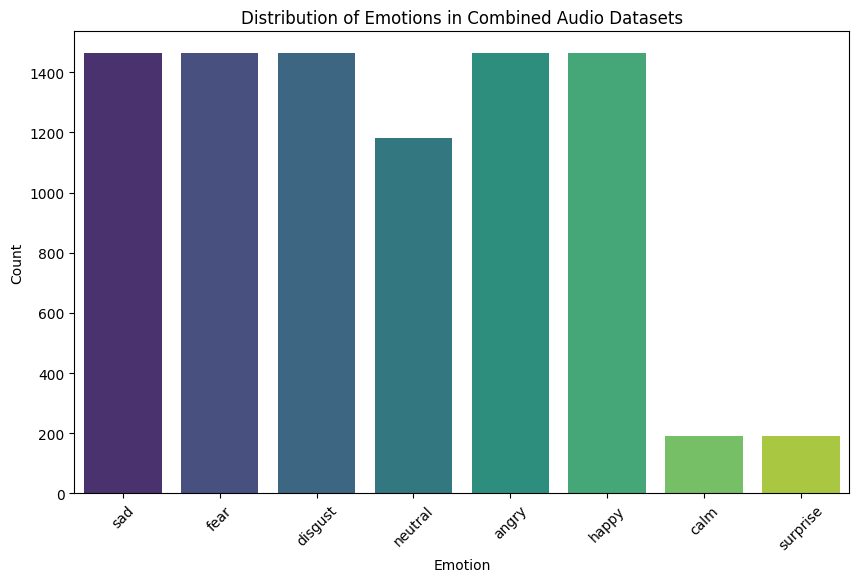

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='Emotions', data=combined_df, palette='viridis')
plt.title('Distribution of Emotions in Combined Audio Datasets')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
len(combined_df)

8882

In [ ]:
# Count the number of samples (rows) in the DataFrame
num_samples = combined_df.shape[0]
print(f"Number of samples in the DataFrame: {num_samples}")


Number of samples in the DataFrame: 8882


In [ ]:
# Number of unique labels (emotions)
num_labels = combined_df['Emotions'].nunique()
print(f"Number of unique labels: {num_labels}")


Number of unique labels: 8


In [ ]:
# Count the occurrences of each label
label_counts = combined_df['Emotions'].value_counts()

# Print the labels and their counts
print("Labels and their counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Labels and their counts:
sad: 1463
fear: 1463
disgust: 1463
angry: 1463
happy: 1463
neutral: 1183
calm: 192
surprise: 192


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your emotion labels and transform them into numerical labels
numerical_labels = label_encoder.fit_transform(combined_df['Emotions'])

# Add the numerical labels as a new column to your DataFrame
combined_df['Numerical_Labels'] = numerical_labels

# Print the mapping between emotion labels and numerical labels
for original_label, numerical_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_label}: {numerical_label}")

angry: 0
calm: 1
disgust: 2
fear: 3
happy: 4
neutral: 5
sad: 6
surprise: 7


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

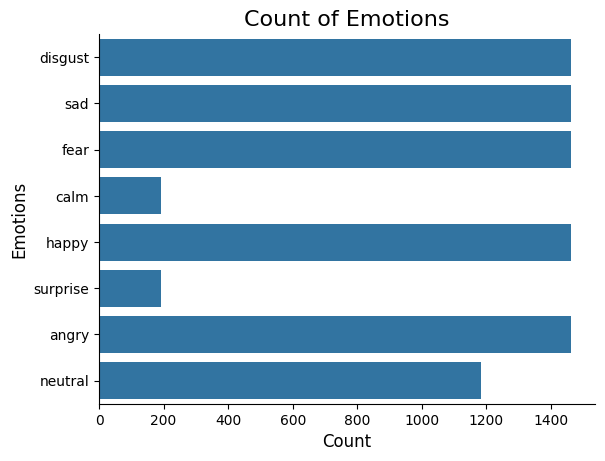

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.label)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
# Concatenate all DataFrames
data_path = pd.concat([Crema_df, Ravdess_df, Savee_df, Tess_df], axis=0, ignore_index=True)

# Display the first few rows to verify
data_path.head()


label                                          Path
0      sad  /content/cremad/AudioWAV/1009_IEO_SAD_HI.wav
1     fear  /content/cremad/AudioWAV/1078_TIE_FEA_XX.wav
2  disgust  /content/cremad/AudioWAV/1042_IWW_DIS_XX.wav
3      sad  /content/cremad/AudioWAV/1027_IWW_SAD_XX.wav
4      sad  /content/cremad/AudioWAV/1021_TIE_SAD_XX.wav

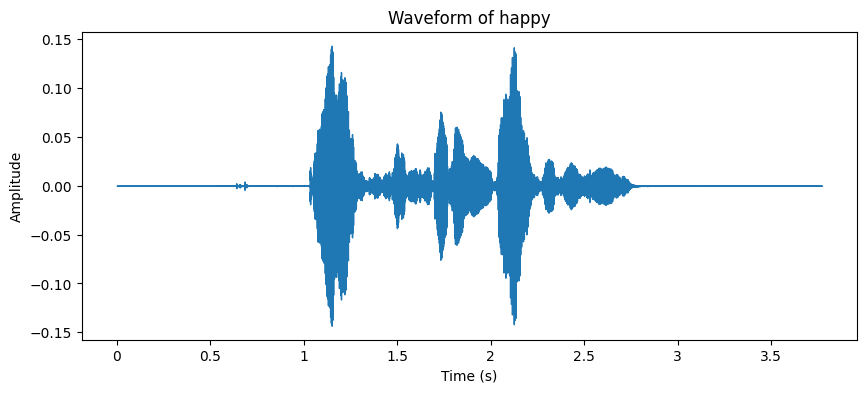

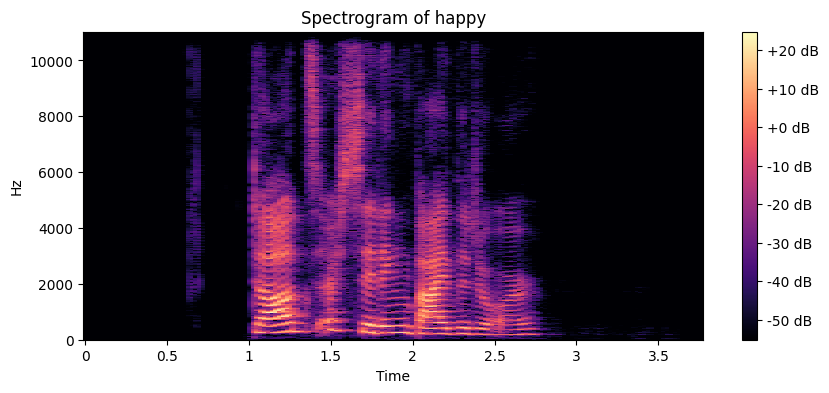

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Define the emotion you're interested in
emotion = 'happy'

# Get the path of the first audio file with the emotion 'fear'
path = np.array(data_path.Path[data_path.label== emotion])[0]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Function to create a waveform plot
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveform of {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Function to create a spectrogram
def create_spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {emotion}')
    plt.show()

# Create the waveform plot
create_waveplot(data, sampling_rate, emotion)

# Create the spectrogram
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


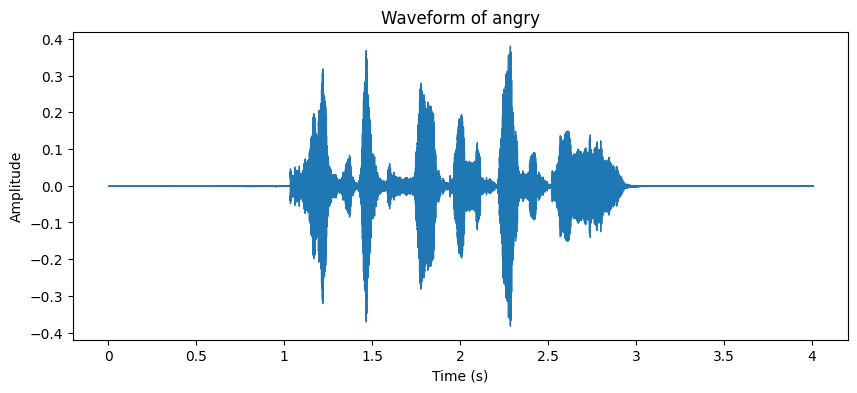

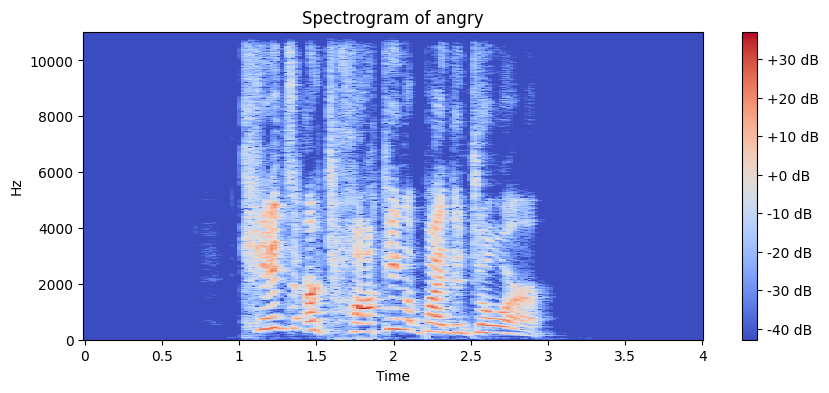

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

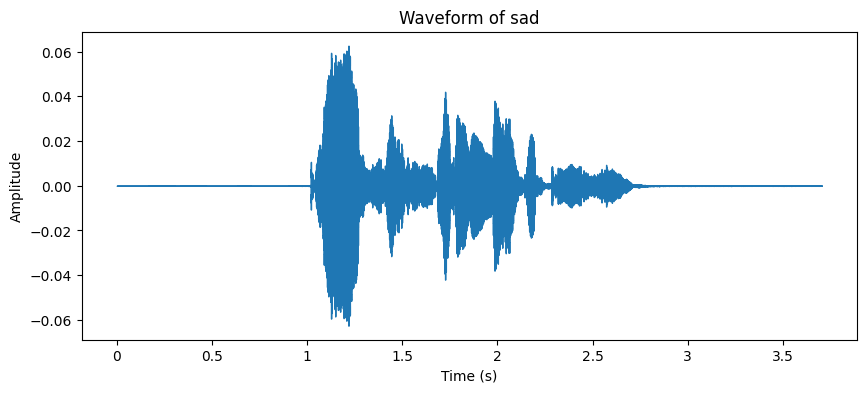

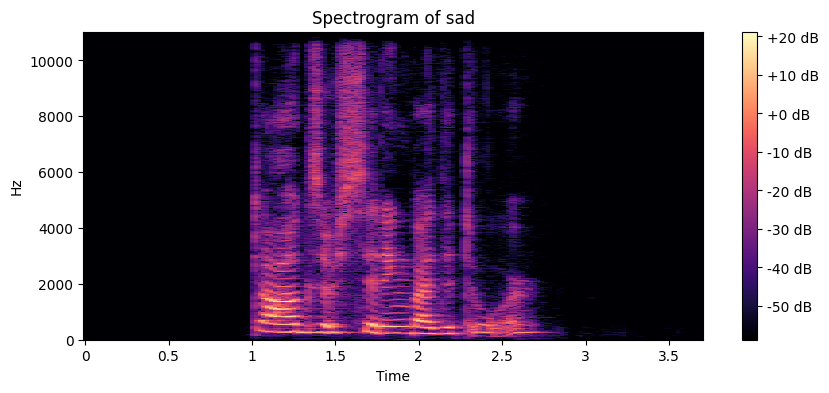

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

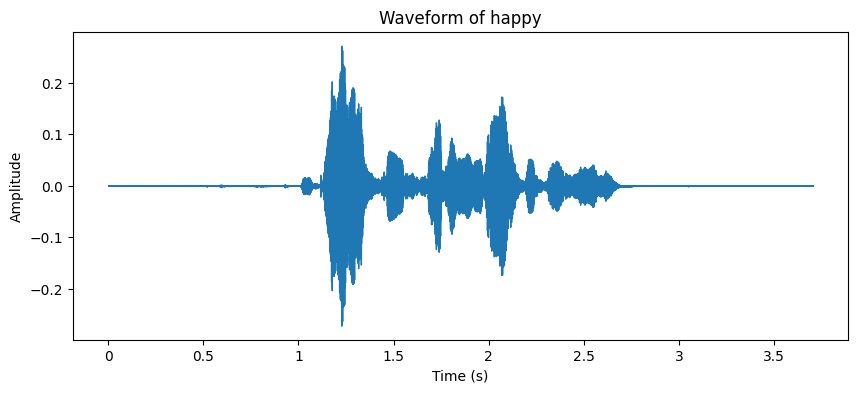

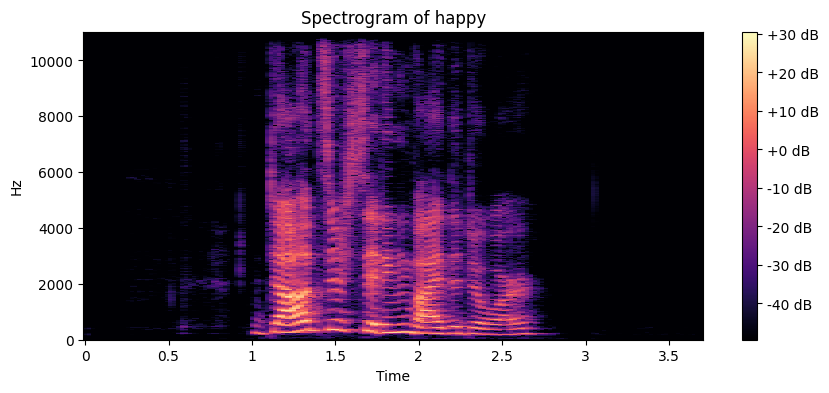

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)  # Pass 'rate' as a keyword argument

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)
    # Pass sampling_rate and pitch_factor as keyword arguments 'sr' and 'n_steps'


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

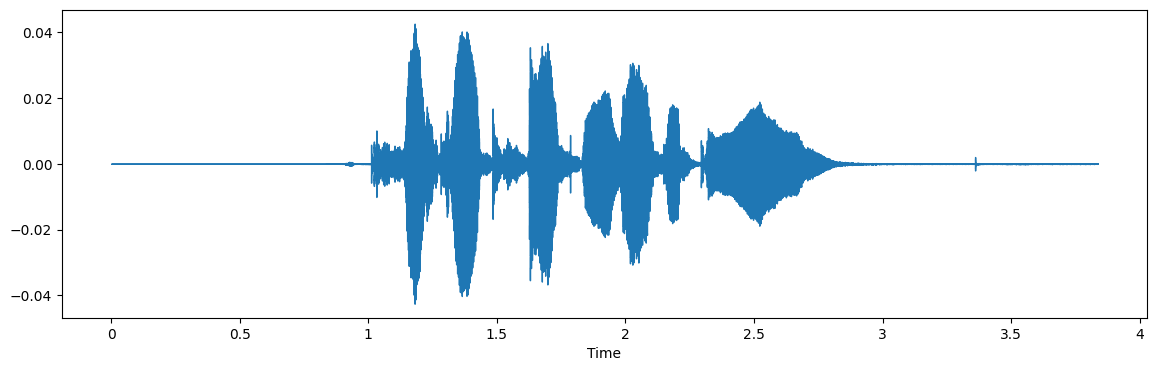

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate) # Use waveshow instead of waveplot
Audio(path)


#### 2. Noise Injection

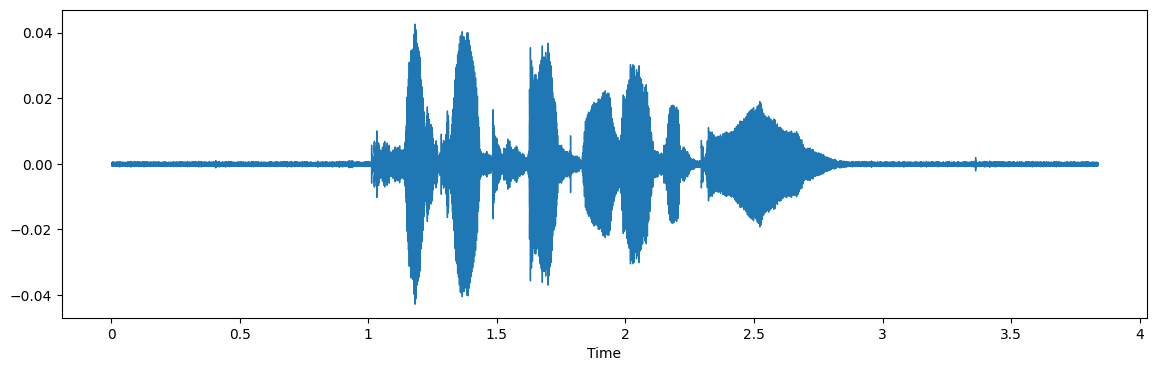

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

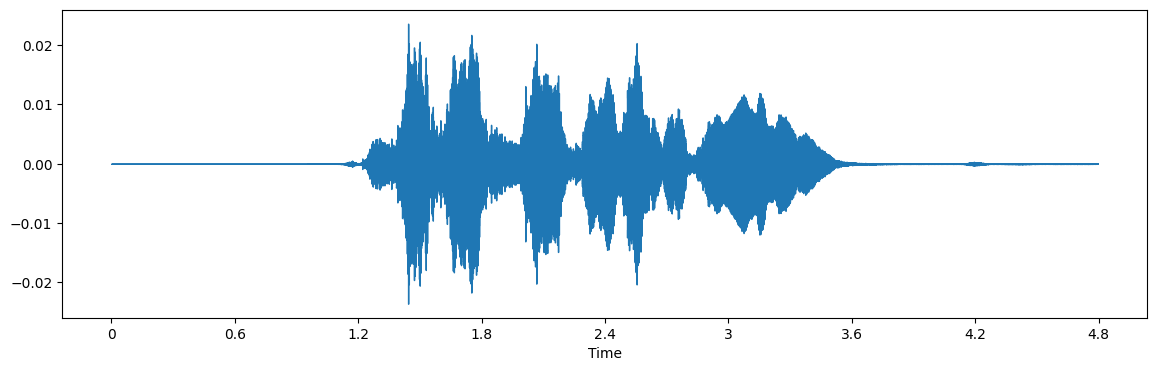

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

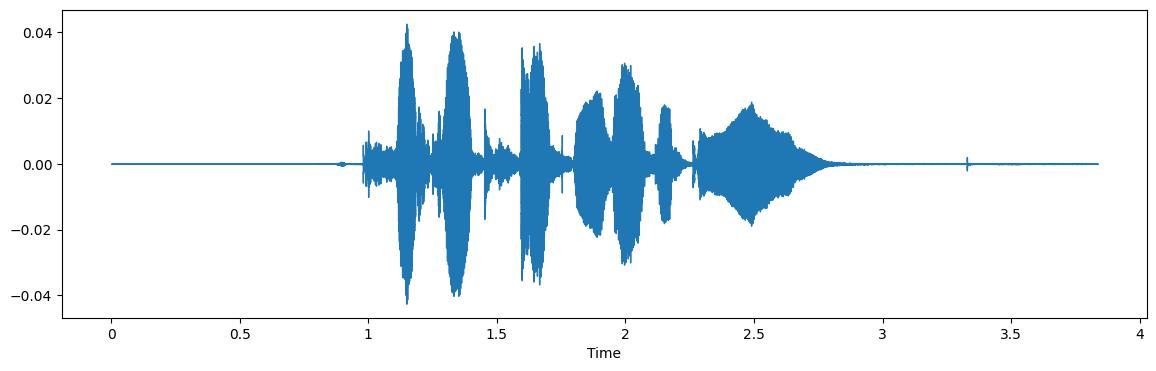

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

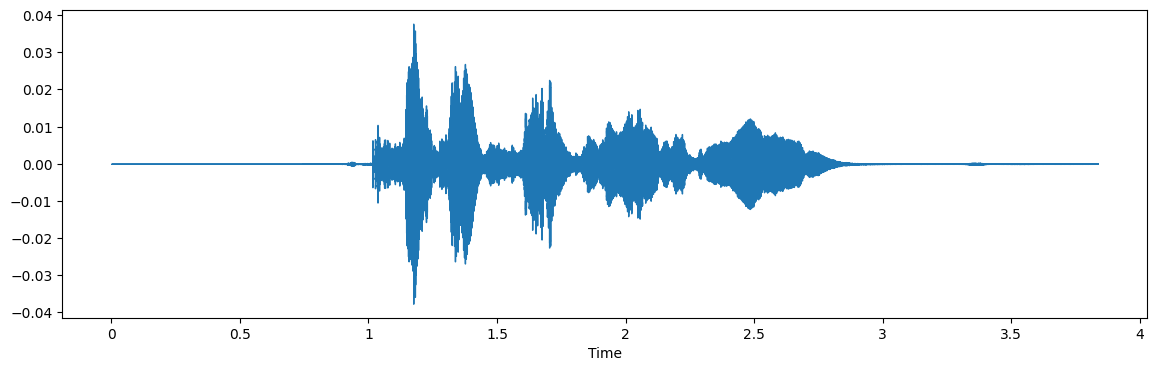

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.label):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

KeyboardInterrupt: 

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
import pickle

# Save features and labels to a file
with open('extracted_features.pkl', 'wb') as f:
    pickle.dump((X, Y), f)


NameError: name 'X' is not defined

In [ ]:
import numpy as np

# Save features and labels as numpy arrays
np.save('X.npy', np.array(X))
np.save('Y.npy', np.array(Y))


# From here we start without re extracting the features


In [ ]:
# Load features and labels
X = np.load('X.npy', allow_pickle=True)
Y = np.load('Y.npy', allow_pickle=True)

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.160314  0.554882  0.459888  0.435709  0.494848  0.557125  0.618065   
1  0.206416  0.597722  0.586177  0.484699  0.502106  0.552891  0.646513   
2  0.204000  0.579614  0.576922  0.488326  0.469532  0.457610  0.549334   
3  0.153840  0.453279  0.401890  0.381668  0.458616  0.384913  0.370057   
4  0.260914  0.607660  0.571998  0.635368  0.630764  0.577908  0.526071   

          7         8         9  ...       153       154       155       156  \
0  0.605618  0.562079  0.617717  ...  0.001170  0.001297  0.000857  0.000531   
1  0.659686  0.631201  0.597458  ...  0.001171  0.001297  0.000857  0.000531   
2  0.626583  0.614571  0.593946  ...  0.000295  0.000166  0.000204  0.000223   
3  0.383694  0.449063  0.642368  ...  0.000019  0.000020  0.000013  0.000022   
4  0.538550  0.673120  0.726427  ...  0.000072  0.000071  0.000062  0.000073   

        157       158       159       160           161   labels  
0  0.001067  0.001373  0.000582  0.000167  5.334832e-06  disgust  
1  0.001069  0.001373  0.000582  0.000167  5.358513e-06  disgust  
2  0.000171  0.000153  0.000252  0.000150  4.870472e-06  disgust  
3  0.000008  0.000009  0.000014  0.000009  8.019702e-07      sad  
4  0.000060  0.000060  0.000066  0.000063  5.391611e-05      sad  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((184, 162), (184, 8), (62, 162), (62, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((184, 162), (184, 8), (62, 162), (62, 8))

## Modelling

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
from tensorflow.keras import regularizers

# Add L2 regularization to a layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

In [ ]:
from tensorflow.keras.layers import Dropout

# Add dropout after a layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # 50% dropout rate

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

In [ ]:

history=model.fit(x_train, y_train, batch_size=64, epochs=80, validation_data=(x_test, y_test), callbacks=[rlrp])

In [ ]:
model.save('/content/drive/My Drive/my_model4.0.keras')


In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

# 'epochs' should match the number of epochs your model was trained for
epochs = [i for i in range(len(history.history['loss']))]  # Use the length of the history

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 59% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam # Or any optimizer you prefer

# Load your saved model
model = load_model('/content/drive/MyDrive/my_model.keras')

# Compile the model again with a chosen optimizer
# This step is crucial when you load a model and want to retrain/fine-tune
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune with additional training data or epochs
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
from tensorflow.keras.applications import VGG16

# Assuming your images are RGB and of a standard size like 32x32
input_shape = (32, 32, 3)  # Adjust this based on your actual image dimensions

# Load a pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add your custom layers on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Make sure x_train is preprocessed and reshaped to match the input_shape
model.fit(x_train.reshape(-1, *input_shape), y_train, epochs=10, validation_data=(x_test, y_test))